# Data loading

Training data is distributed in 3 different folders (set a, b and c).
Each file has its raw image (.mhd), lung mask (\_lm.mhd), and fissure mask (\_fm.mhd).

In [2]:
import os, random
import ntpath
import SimpleITK
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, Activation, Deconvolution3D, Cropping3D, UpSampling3D
from keras.optimizers import Adam

K.set_image_data_format("channels_first")

from keras.layers.merge import concatenate


Using TensorFlow backend.


In [3]:
workdir = '/projects/0/ismi2018/FINALPROJECTS/CHESTCT_FISSURE_INTEGRITY/'
train_A_images = os.path.join(workdir, 'set-a')
train_B_images = os.path.join(workdir, 'set-b')
train_C_images = os.path.join(workdir, 'set-c')

a26_fm.mhd
(221, 307, 521)


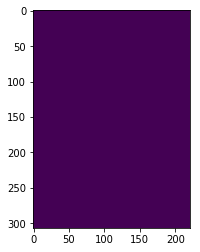

In [4]:
#Print one file:
case = os.path.join(train_A_images, random.choice(os.listdir(train_A_images)))
case_filename = os.path.splitext(ntpath.basename(case))[0] + '.mhd'
img = SimpleITK.ReadImage(train_A_images+ '/' + case_filename)

piece = SimpleITK.GetArrayViewFromImage(img)[50,:,:] #<-- Specify a number for the z-index slice
print(case_filename)
print(img.GetSize())
plt.imshow(piece)


In [5]:
''' Helper function '''
def load_unique_image_names(folder):
    
    uniqueimglist = []
    for file in os.listdir(folder):
        file = file.replace(".mhd", "")
        file = file.replace("_lm", "")
        file = file.replace("_fm", "")
        file = file.replace(".zraw", "")
        if ".csv" not in file:
            uniqueimglist.append(file)
    uniqueimglist = list(set(uniqueimglist))
    return uniqueimglist


''' Load training data from a folder'''
def load_training_set(folder):
    fileList = load_unique_image_names(folder)
    
    trainSet = []
    for file in fileList:
        filePath = folder + '/' + file
        image = lungMask = fissureMask = None
        try:
            image = SimpleITK.ReadImage(filePath + '.mhd')
            lungMask = SimpleITK.ReadImage(filePath + '_lm.mhd')
            fissureMask = SimpleITK.ReadImage(filePath + '_fm.mhd')
            label = file[0]
            trainSet.append({'name': file, 
                         'image': image, 
                         'lungmask': lungMask,
                         'fissuremask': fissureMask,
                         'label': label})
        except :
            print("Error reading file: " + file)
            
    return trainSet

def get_exact_csv_set(folder, label):
    return pd.read_csv(folder + '/LUT-' + label + '.csv')
    


In [6]:
print("Loading train set...")
training = load_training_set(train_A_images)
training.extend(load_training_set(train_B_images))
training.extend(load_training_set(train_C_images))
training = pd.DataFrame(training)
print("Done loading!")

Loading train set...
Done loading!


Accessing the LUT csv files to attach the exact percentages to the training set:

In [7]:

exact = get_exact_csv_set(train_A_images, 'a') # 60
exact = exact.append(get_exact_csv_set(train_B_images, 'b'), ignore_index=True) # 38
exact = exact.append(get_exact_csv_set(train_C_images, 'c'), ignore_index=True) # 102
exact = exact.rename(columns={'Fissure_completeness': 'completeness'})

print("exact size: ", exact.size)
print("training size: ", training.size)

'''
emptyList = []
trainList = []
for el in training['name']:
    trainList.append(el)
    if el not in exact['New ID']:
        emptyList.append(el)
print(sorted(emptyList))
print(sorted(trainList))
print("Do the csv files represent the whole training set?")
print(sorted(trainList)== sorted(emptyList) )

exact['New ID'].iloc[31]
'''


# Join the csv set with the training set
training = pd.merge(training, exact, left_on='name', right_on='New ID')
training = training.drop('New ID', 1)


exact size:  200
training size:  500


In [8]:
training.head(5)

,fissuremask,image,label,lungmask,name,completeness
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-80, -150, -146, -164, -128, -95, -26, -112, ...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a02,33.3554
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 67, 30, 37, 22, 1, -27, -95, -133, -104, ...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a03,39.0370
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 88, 43, 54, 23, 40, 4, -6, 17, 22, 40, -2...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a07,56.4871
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-126, -131, -72, -69, -154, -116, -61, -101, ...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a08,57.0327
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[66, 67, 48, 39, 43, 73, 78, 42, 43, 68, 74, 4...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a10,64.0833


## Accessing the data

We attached the labels LUT-a.csv (etc...) to the training data in order to make it into a regression problem. Now, we would like to save this dataframe to file. Unfortunately, this can't be done, as the image elements aren't pickle-able (_Python can't pickle swigpy objects_).



- (Data) Raw images can be accessed by utilizing `training['image'].values`. This will return an array with the SimpleITK images.
- (Label) Classification labels _(a,b,c)_ can be obtained by `training['label'].values`.
- (Label) Regression labels _Fissure completeness percentage (%)_ can be obtained by `training['completeness'].values`.

Save the training set to file

*Actually can't be done, as it can't pickle swigpy objects..*

In [9]:
#store = pd.HDFStore('database.h5')
#store['trainingset'] = training

In [10]:
#training.to_pickle('./train-data.pkl')

Completeness:  39.037


array([0, 2, 4], dtype=uint8)

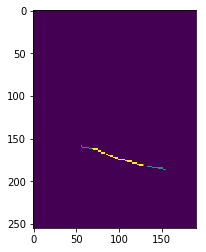

In [11]:
img = training['fissuremask'].iloc[1]
piece = SimpleITK.GetArrayViewFromImage(img)[240,:,:]
plt.imshow(piece)
print("Completeness: ", training['completeness'].iloc[1])
np.unique(piece)

# Patch Generator

# U-net

In [12]:
# Loss calculation for 3D U-net
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)

In [13]:
def create_network(input_shape):
    
    levels = list()
    inputs = Input(input_shape)
    # Block 1
    layer1 = Conv3D(32*(2**0), (3,3,3), padding='valid', strides=1)(inputs)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**0), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)
    pool = MaxPooling3D(pool_size=(2,2,2))(layer2)
    levels.append([layer1, layer2, pool])
    # Block 2
    layer1 = Conv3D(32*(2**1), (3,3,3), padding='valid', strides=1)(pool)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**1), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)
    pool = MaxPooling3D(pool_size=(2,2,2))(layer2)
    levels.append([layer1, layer2, pool])
    # Block 3
    layer1 = Conv3D(32*(2**2), (3,3,3), padding='valid', strides=1)(pool)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**2), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)
    pool = MaxPooling3D(pool_size=(2,2,2))(layer2)
    levels.append([layer1, layer2, pool])
    # Block 4
    layer1 = Conv3D(32*(2**3), (3,3,3), padding='valid', strides=1)(pool)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**3), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)
    levels.append([layer1, layer2])

    # Block 5
    layer0 = UpSampling3D(size=2)(layer2)
    #layer0 = Conv3D(32*(2**2), (2,2,2))(layer0)
    crop = levels[2][1]
    size = (crop._keras_shape[-3] - layer0._keras_shape[-3],
            crop._keras_shape[-2] - layer0._keras_shape[-2], 
            crop._keras_shape[-1] - layer0._keras_shape[-1])
    size = ((int(np.floor(size[0]/2)),int(np.ceil(size[0]/2))),
            (int(np.floor(size[1]/2)),int(np.ceil(size[1]/2))),
            (int(np.floor(size[2]/2)),int(np.ceil(size[2]/2))))
    crop = Cropping3D(cropping=size)(crop)
    concatenate([layer0, crop],axis=1)
    layer1 = Conv3D(32*(2**2), (3,3,3), padding='valid', strides=1)(layer0)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**2), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)
    # Block 6
    layer0 = UpSampling3D(size=2)(layer2)
    #layer0 = Conv3D(32*(2**1), (2,2,2))(layer0)
    crop = levels[1][1]
    size = (crop._keras_shape[-3] - layer0._keras_shape[-3],
            crop._keras_shape[-2] - layer0._keras_shape[-2], 
            crop._keras_shape[-1] - layer0._keras_shape[-1])
    size = ((int(np.floor(size[0]/2)),int(np.ceil(size[0]/2))),
            (int(np.floor(size[1]/2)),int(np.ceil(size[1]/2))),
            (int(np.floor(size[2]/2)),int(np.ceil(size[2]/2))))
    crop = Cropping3D(cropping=size)(crop)
    concatenate([layer0, crop],axis=1)
    layer1 = Conv3D(32*(2**1), (3,3,3), padding='valid', strides=1)(layer0)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**1), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)
    # Block 7
    layer0 = UpSampling3D(size=2)(layer2)
    #layer0 = Conv3D(32*(2**0), (2,2,2))(layer0)
    crop = levels[0][1]
    size = (crop._keras_shape[-3] - layer0._keras_shape[-3],
            crop._keras_shape[-2] - layer0._keras_shape[-2], 
            crop._keras_shape[-1] - layer0._keras_shape[-1])
    size = ((int(np.floor(size[0]/2)),int(np.ceil(size[0]/2))),
            (int(np.floor(size[1]/2)),int(np.ceil(size[1]/2))),
            (int(np.floor(size[2]/2)),int(np.ceil(size[2]/2))))
    crop = Cropping3D(cropping=size)(crop)
    concatenate([layer0, crop],axis=1)
    layer1 = Conv3D(32*(2**0), (3,3,3), padding='valid', strides=1)(layer0)
    layer1 = Activation('relu')(layer1)
    layer2 = Conv3D(32*(2**0), (3,3,3), padding='valid', strides=1)(layer1)
    layer2 = Activation('relu')(layer2)

    final = Conv3D(3, (1, 1, 1))(layer2)
    final = Activation('softmax')(final)
    model = Model(inputs=inputs, outputs=final)

    model.compile(optimizer=Adam(lr=0.00001), loss=dice_coefficient_loss, metrics=[dice_coefficient])
    model.summary()
    return model

In [15]:
create_network([1,666,666,1337])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 666, 666, 1337) 0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 32, 664, 664, 1335 896       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 664, 664, 1335 0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 32, 662, 662, 1333 27680     
_________________________________________________________________
activation_17 (Activation)   (None, 32, 662, 662, 1333 0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 32, 331, 331, 666) 0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 64, 329, 329, 664) 55360     
__________